# transfer learning with fine tuning

In [1]:
import tensorflow as tf

In [2]:
def load_and_prep_image(filename,img_shape=224,scale=True):
    
    # read in the image
    img=tf.io.read_file(filename)
    # decode it into tensor
    img=tf.image.decode_jpeg(img)
    # resize the image
    img=tf.image.resize(img,[img_shape,img_shape])
    if scale:
        # rescale the image
        return img/255.
    else:
        return img

In [3]:
# lets create a function to plot our loss curves
import matplotlib.pyplot as plt

# plot the validation and trainng curves
def plot_loss_curves(history):
    
    # plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history["val_loss"])
    plt.title("model_loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend(["Train","Test"])
    
    # plot accuracy
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model_accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend(["Train","Test"]); 

In [4]:
# create a tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, expirement_name):
    log_dir=dir_name+ "/" + expirement_name+ "/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [5]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

## lets get some data

In [6]:
# check out how many directories are in data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# creat a train and test dir
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [8]:
img_size=(224,224)
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                              batch_size=32,
                                                              image_size=img_size,
                                                              label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                             batch_size=32,
                                                             image_size=img_size,
                                                             label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## building model with functional api

In [10]:
# create model with tf.keras.application
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# freeze the base model(so that underlying pre_trained patters aren't updated)
base_model.trainable=False

# create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# if we using resnet50V2 you will need to normalize inputs
# x=tf.keras.layers.experimenta.preprocessing.Rescaling(1./255)(inputs)

# pass the inputs to the base model
x=base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

# average pool the output of the base model(aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after global pooling: {x.shape}")

# create output activation layer
outputs=tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine the inputs with outputs in a model
model_0=tf.keras.Model(inputs,outputs)

# compile the model
model_0.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# fit the model
history=model_0.fit(train_data, epochs=5,steps_per_epoch=len(train_data),
                   validation_data=test_data, validation_steps=int(0.25 * len(test_data)),
                   callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                         expirement_name="10_percebt_feature_extraction")])

shape after passing inputs through base model: (None, 7, 7, 1280)
shape after global pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percebt_feature_extraction/20231015-221001
Epoch 1/5
24/24 [==============================] - 39s 433ms/step - loss: 1.8868 - accuracy: 0.4107 - val_loss: 1.3198 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 6s 236ms/step - loss: 1.0982 - accuracy: 0.7560 - val_loss: 0.8683 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 6s 235ms/step - loss: 0.7875 - accuracy: 0.8213 - val_loss: 0.7067 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 6s 233ms/step - loss: 0.6406 - accuracy: 0.8627 - val_loss: 0.5960 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 6s 235ms/step - loss: 0.5508 - accuracy: 0.8720 - val_loss: 0.5585 - val_accuracy: 0.8635


In [11]:
# evaluat on full test data
model_0.evaluate(test_data)

79/79 [==============================] - 12s 144ms/step - loss: 0.5555 - accuracy: 0.8564


[0.5555056929588318, 0.8564000129699707]

In [12]:
# ckeck the layers
for layers_number , layers in enumerate(base_model.layers):
    print(layers_number, layers.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


## make model with 1 percent of data

In [14]:
train_dir="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [15]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [16]:
# set dataloaders
img_size=(224,224)
train_data=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              batch_size=32,
                                                              label_mode="categorical",
                                                              image_size=img_size)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             batch_size=32,
                                                             label_mode="categorical",
                                                             image_size=img_size)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### adding data augmentation right into model

In [118]:
from tensorflow.keras import layers

In [125]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

### visualize our data augementation layer

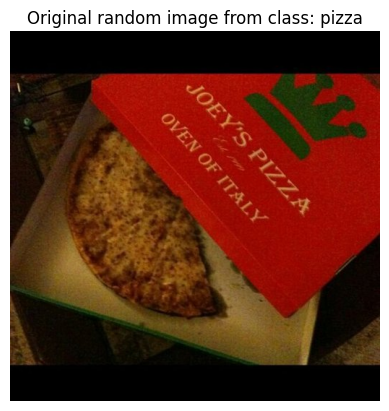

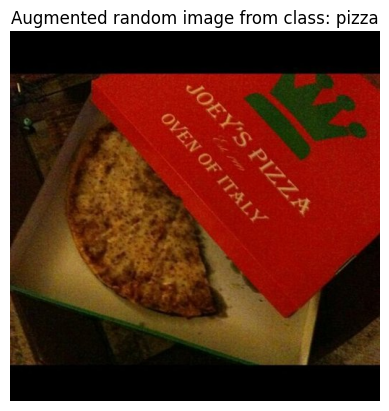

In [133]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path)
img = tf.cast(tf.expand_dims(img, 0), tf.float32)# read in the chosen target image
plt.imshow(tf.squeeze(img)/255.) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(img) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

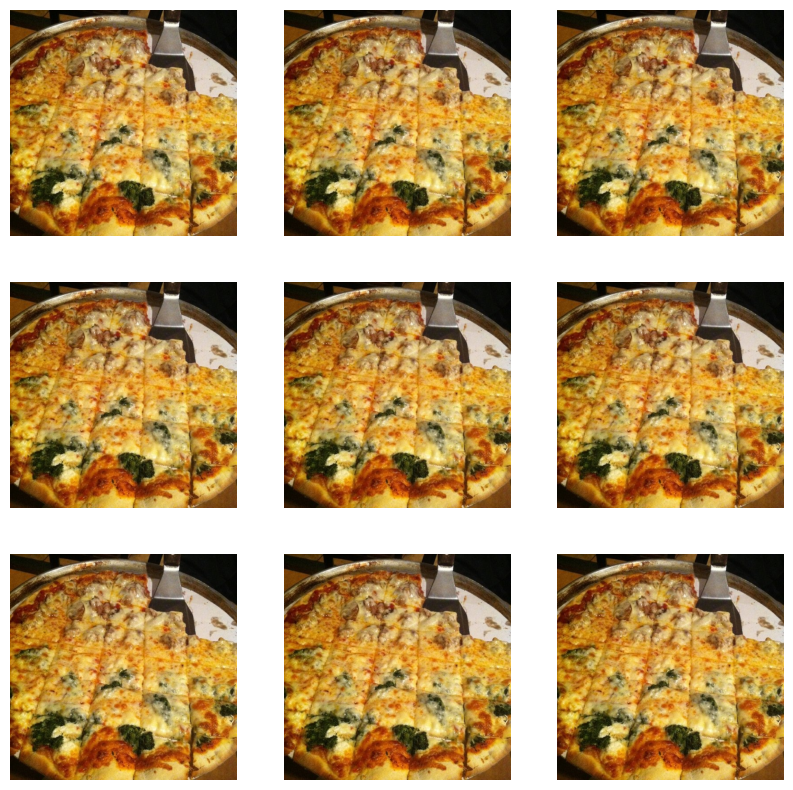

In [114]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tf.squeeze(augmented_img)/255.)
  plt.axis("off")